# Setup

In [73]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import networkx as nx
import random

In [75]:
data = pd.read_csv('AMOTRA_MENOR.csv', sep=';')
# tirar limite de colunas
pd.set_option('display.max_columns', None)

# Limpeza dos dados

In [76]:
data

,INDICE,LATITUDE,LONGITUDE,CODIGO_ROTA,SEQUENCIA,LOGRADOURO,NUMERO
0,400121201.0,-22.811460,-43.326529,72_203,269.0,ATILIO PARIM,509.0
1,400341582.0,-22.809989,-43.329211,72_204,80.0,ATILIO PARIM,201.0
2,400133758.0,-22.810458,-43.324248,72_202,391.0,MIN ARTUR COSTA,404.0
3,400091624.0,-22.809244,-43.326239,72_202,175.0,VIANA DO CASTELO,39.0
4,400003468.0,-22.803470,-43.325527,72_207,205.0,FLAVIO DA SILVEIRA,12.0
...,...,...,...,...,...,...,...
6074,400091760.0,-22.805479,-43.321785,72_210,234.0,ATILIO VIVACQUA,240.0
6075,403469601.0,-22.804782,-43.327831,83_115,1.0,RODOLFO CHAMBELLAND,736.0
6076,400090898.0,-22.809487,-43.319933,72_211,390.0,CHARLES GOUNOD,591.0
6077,401221294.0,-22.805086,-43.328185,72_206,341.0,RODOLFO CHAMBELLAND,737.0


In [77]:
len(data['CODIGO_ROTA'].unique())

61

In [78]:
# Filter the DataFrame to keep only rows where 'CODIGO_ROTA' starts with '72'
data = data[data['CODIGO_ROTA'].str.startswith('72')]
data = data.reset_index()
data = data.drop(columns = 'index')

In [79]:
data['CODIGO_ROTA'].unique()

array(['72_203', '72_204', '72_202', '72_207', '72_212', '72_206',
       '72_208', '72_205', '72_210', '72_201', '72_209', '72_213',
       '72_214', '72_211', '72_810', '72_83', '72_111'], dtype=object)

# Processamento

In [80]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth raio da terra em kilometros
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 1000  # Convertendo para metros

In [81]:
def build_distance_matrix_vectorized(data):
    latitudes = data['LATITUDE'].to_numpy()
    longitudes = data['LONGITUDE'].to_numpy()

    lat1 = latitudes[:, np.newaxis]
    lon1 = longitudes[:, np.newaxis]
    lat2 = latitudes
    lon2 = longitudes

    distance_matrix = haversine(lat1, lon1, lat2, lon2)
    
    return distance_matrix

In [82]:
outliers = []
for name, group in data.groupby('CODIGO_ROTA'):
    distance_matrix = haversine(group['LATITUDE'].values[:, np.newaxis], group['LONGITUDE'].values[:, np.newaxis],
                                group['LATITUDE'].values, group['LONGITUDE'].values)
    mean_distances = distance_matrix.mean(axis=1)
    threshold = 2 * mean_distances.mean()  # Adjust threshold as needed
    outlier_indices = group.index[mean_distances < threshold].tolist()
    outliers.extend(outlier_indices)

# Find closest route for each outlier
reassignment = {}
for outlier_idx in outliers:
    min_distance = float('inf')
    closest_route = None
    outlier_lat, outlier_lon = data.loc[outlier_idx, ['LATITUDE', 'LONGITUDE']]
    for name, group in data.groupby('CODIGO_ROTA'):
        if name == data.loc[outlier_idx, 'CODIGO_ROTA']:
            continue
        distances = haversine(outlier_lat, outlier_lon, group['LATITUDE'].values, group['LONGITUDE'].values)
        nearest_point_distance = distances.min()
        if nearest_point_distance < min_distance:
            min_distance = nearest_point_distance
            closest_route = name
    reassignment[outlier_idx] = closest_route

# Update the data with the new route assignments
for idx, new_route in reassignment.items():
    data.at[idx, 'CODIGO_ROTA'] = new_route

In [84]:
data['CODIGO_ROTA'].unique()

array(['72_205', '72_206', '72_202', '72_209', '72_208', '72_210',
       '72_810', '72_204', '72_214', '72_212', '72_211', '72_213',
       '72_203', '72_207', '72_201', '72_111', '72_83'], dtype=object)

In [85]:
# Matriz de distancia para cada rota
distance_matrix_dict = {}
for name, group in data.groupby('CODIGO_ROTA'):
    distance_matrix_dict[name] = build_distance_matrix_vectorized(group) * 1000

C:\Users\fexex\AppData\Local\Temp\ipykernel_19868\3879450831.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_routes))


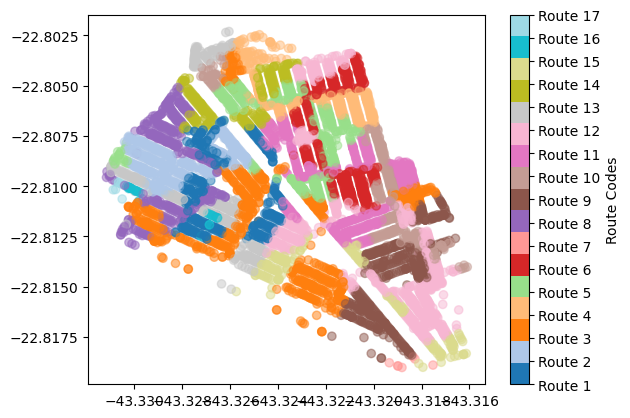

In [86]:
# Define the unique routes and their corresponding indices for color mapping
unique_routes = data['CODIGO_ROTA'].unique()
route_indices = {route: idx for idx, route in enumerate(unique_routes)}

# Select a colormap
colormap = plt.cm.get_cmap('tab20', len(unique_routes))

# Assign colors to each route based on its index in the unique_routes array
colors = [colormap(route_indices[route]) for route in data['CODIGO_ROTA']]

# Create a plot with explicitly defined axes
fig, ax = plt.subplots()
sc = ax.scatter(data['LONGITUDE'], data['LATITUDE'], color=colors, alpha=0.5)

# Create a colorbar with the same colormap and normalization
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=len(unique_routes)-1)),
                    ax=ax, ticks=np.arange(len(unique_routes)))
cbar.set_label('Route Codes')
cbar.set_ticklabels([f'Route {i+1}' for i in range(len(unique_routes))])  # Optional: adjust labels

plt.show()

# Algoritmo

In [59]:
def nearest_neighbors(distance_matrix):
    n = len(distance_matrix)
    visited = set()
    route = [0]
    visited.add(0)
    
    current = 0
    while len(visited) < n:
        next_dist = np.inf
        next_node = None
        for i in range(n):
            if i not in visited and distance_matrix[current, i] < next_dist:
                next_dist = distance_matrix[current, i]
                next_node = i
        visited.add(next_node)
        route.append(next_node)
        current = next_node
    return route

C:\Users\fexex\AppData\Local\Temp\ipykernel_19868\2855546715.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(routes))


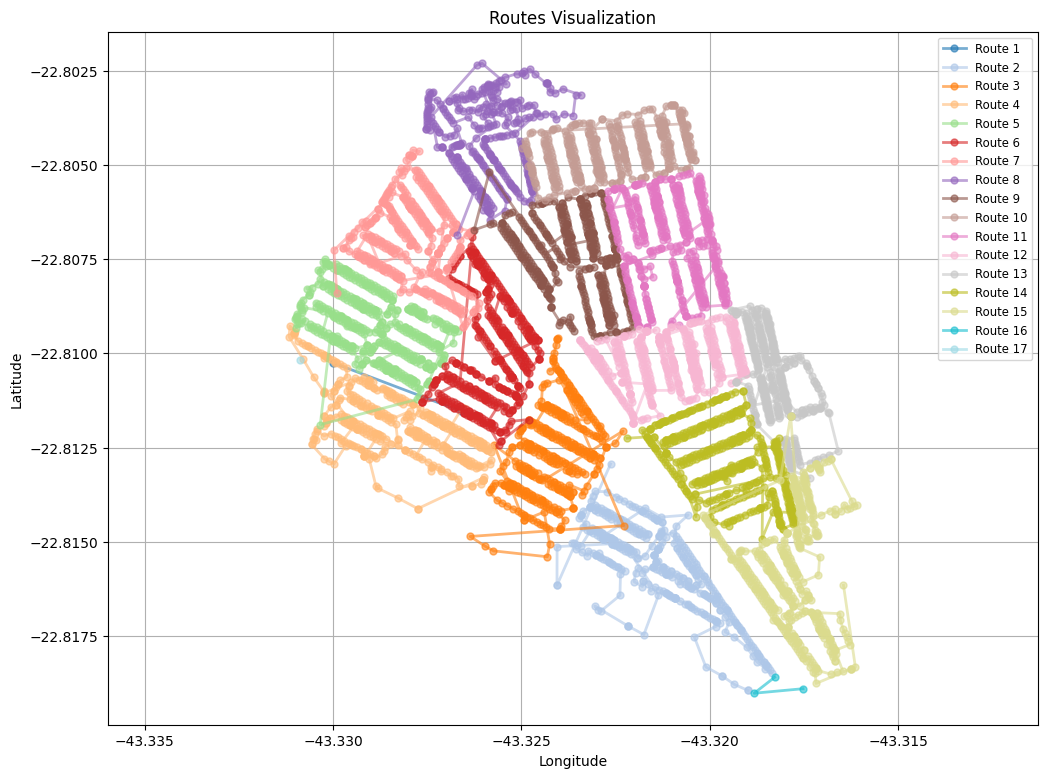

In [60]:
def plot_routes(data, routes):
    plt.figure(figsize=(12, 9))
    
    # Set a colormap
    colors = plt.cm.get_cmap('tab20', len(routes))
    
    for idx, route in enumerate(routes):
        # Extract coordinates for the route
        coordinates = data.iloc[route][['LONGITUDE', 'LATITUDE']].values
        
        # Plot each route
        plt.plot(coordinates[:, 0], coordinates[:, 1], marker='o', markersize=5, 
                 linewidth=2, alpha=0.6, color=colors(idx), label=f'Route {idx + 1}')

    plt.title("Routes Visualization")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend(loc='best', fontsize='small')
    
    # Set equal scaling by aspect ratio
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

# Generate a dictionary of routes based on route codes
routes_dict = {}
for name, group in data.groupby('CODIGO_ROTA'):
    distance_matrix = distance_matrix_dict[name]
    route_indices = nearest_neighbors(distance_matrix)
    routes_dict[name] = group.iloc[route_indices].index.tolist()


plot_routes(data, list(routes_dict.values()))


In [17]:
data['CODIGO_ROTA'].unique().size

61

In [18]:
filtered_data = sorted_data[(sorted_data['CODIGO_ROTA'] == '72_203')]
filtered_data

,INDICE,LATITUDE,LONGITUDE,CODIGO_ROTA,SEQUENCIA,LOGRADOURO,NUMERO
3436,403526377.0,-22.812222,-43.327796,72_203,1.0,ORGANISTA ANTONIO SILVA,211.0
5080,400547299.0,-22.810383,-43.329637,72_203,1.0,GAL OSCILIO MAIA,163.0
1167,400086729.0,-22.810328,-43.329741,72_203,2.0,GAL OSCILIO MAIA,159.0
439,400252802.0,-22.810285,-43.329820,72_203,3.0,GAL OSCILIO MAIA,147.0
5481,400145353.0,-22.810236,-43.329907,72_203,4.0,GAL OSCILIO MAIA,129.0
...,...,...,...,...,...,...,...
790,400451901.0,-22.810993,-43.329971,72_203,420.0,PROF COSTA RIBEIRO,165.0
3176,400511948.0,-22.810993,-43.329971,72_203,421.0,PROF COSTA RIBEIRO,165.0
460,400494409.0,-22.811122,-43.330052,72_203,422.0,PROF COSTA RIBEIRO,15.0
215,401732570.0,-22.811007,-43.330249,72_203,423.0,RODOLFO CHAMBELLAND,10.0


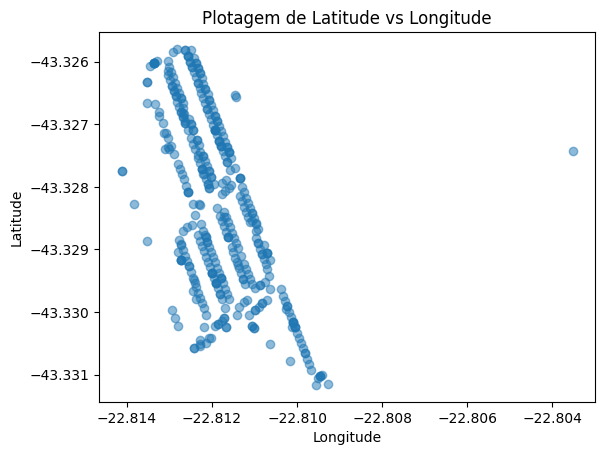

In [19]:
# Plotar os pontos com cores diferentes para cada valor único da coluna 'sequencia'
plt.scatter(filtered_data['LATITUDE'], filtered_data['LONGITUDE'], alpha=0.5)
plt.title('Plotagem de Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

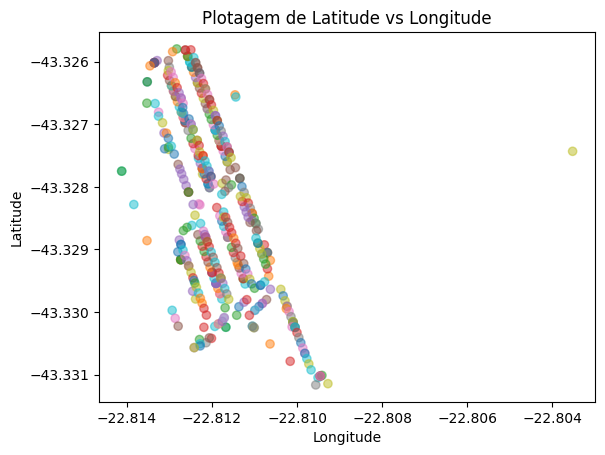

In [20]:
# Gerar uma lista de cores aleatórias do mesmo tamanho que o número de valores únicos na coluna 'sequencia'
cores_aleatorias = [plt.cm.colors.to_hex(random.choice(plt.cm.tab10.colors)) for _ in range(len(filtered_data['SEQUENCIA'].unique()))]

# Criar um dicionário mapeando valores únicos da coluna 'sequencia' para cores aleatórias
cores_por_sequencia = dict(zip(filtered_data['SEQUENCIA'].unique(), cores_aleatorias))

# Criar uma lista de cores com base nos valores da coluna 'sequencia'
cores = [cores_por_sequencia[sequencia] for sequencia in filtered_data['SEQUENCIA']]

# Plotar os pontos com cores diferentes para cada valor único da coluna 'sequencia'
plt.scatter(filtered_data['LATITUDE'], filtered_data['LONGITUDE'], c=cores, alpha=0.5)
plt.title('Plotagem de Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

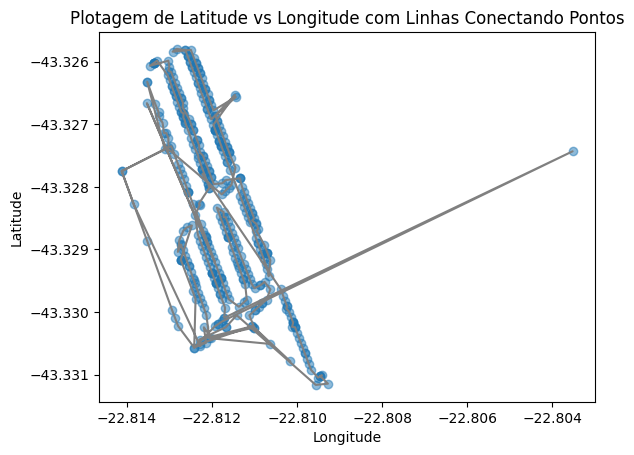

In [21]:
# Seus dados de latitude e longitude
latitude = filtered_data['LATITUDE']
longitude = filtered_data['LONGITUDE']

plt.scatter(latitude, longitude, alpha=0.5)

plt.plot(latitude, longitude, color='gray', linestyle='-')

# Adicionando título e rótulos dos eixos
plt.title('Plotagem de Latitude vs Longitude com Linhas Conectando Pontos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrando o gráfico
plt.show()

In [22]:
# print filtered_data that the longitude is greater than -22.800
filtered_data[filtered_data['LATITUDE'] > -22.807]

,INDICE,LATITUDE,LONGITUDE,CODIGO_ROTA,SEQUENCIA,LOGRADOURO,NUMERO
562,400381569.0,-22.803525,-43.327431,72_203,107.0,OTAVIO MANGABEIRA,622.0


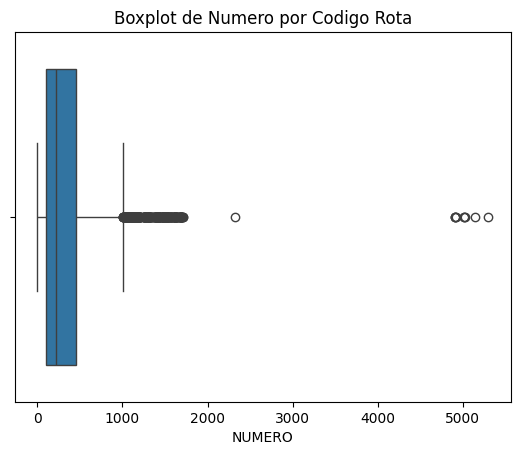

In [23]:
max_num = data['NUMERO'].max()
box_data = data.copy()
# excluir os dados com valor máximo
box_data['NUMERO'] = box_data['NUMERO'].apply(lambda x: x if x != max_num else np.nan)
# excluir dados faltantes
box_data = box_data.dropna(subset=['NUMERO'])

sns.boxplot(x=box_data['NUMERO'])
plt.title('Boxplot de Numero por Codigo Rota')
plt.show()


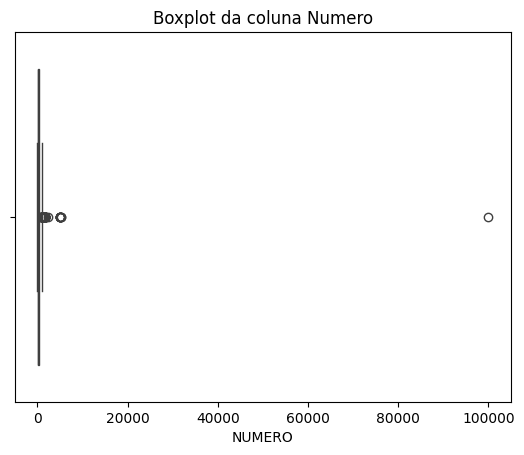

In [24]:
# boxplot da coluna numero
sns.boxplot(x=data['NUMERO'])
plt.title('Boxplot da coluna Numero')
plt.show()

In [25]:
data['NUMERO'].describe()

count     6077.000000
mean       341.013000
std       1328.475353
min          0.000000
25%         97.000000
50%        213.000000
75%        460.000000
max      99975.000000
Name: NUMERO, dtype: float64

In [26]:
data['LATITUDE'].describe()

count    6079.000000
mean      -22.809978
std         0.003608
min       -22.819022
25%       -22.812493
50%       -22.810003
75%       -22.807212
max       -22.801733
Name: LATITUDE, dtype: float64

In [27]:
# check for duplicates in data[LATITUDE, LONGITUDE]
duplicates = data[data.duplicated(subset=['LATITUDE', 'LONGITUDE'], keep=False)]
duplicates

,INDICE,LATITUDE,LONGITUDE,CODIGO_ROTA,SEQUENCIA,LOGRADOURO,NUMERO
15,400086611.0,-22.810693,-43.330415,604_3,28.0,RODOLFO CHAMBELLAND,387.0
22,402279719.0,-22.818946,-43.318989,72_201,4.0,PRES DUTRA,142.0
31,400218852.0,-22.817238,-43.322168,72_201,12.0,PRESIDENTE DUTRA,482.0
41,400397647.0,-22.810354,-43.318004,72_212,285.0,GREGORIO DE MATOS,527.0
45,400360977.0,-22.807347,-43.327218,72_206,168.0,PROF COSTA RIBEIRO,510.0
...,...,...,...,...,...,...,...
6062,402304649.0,-22.817103,-43.319826,72_201,192.0,GAL CORREA E CASTRO,38.0
6065,401924572.0,-22.805256,-43.323471,72_209,350.0,MOZART,141.0
6068,402622242.0,-22.806922,-43.323692,72_208,138.0,SEBASTIAN BACH,291.0
6071,403220629.0,-22.809295,-43.321676,72_210,2.0,GEORGES BIZET,131.0


In [28]:
total = data.shape[0]

In [29]:
parcial = data.shape[0] - duplicates.shape[0] 

In [30]:
(parcial/total) * 100

60.618522783352525

In [31]:
data[(data['LATITUDE'] == -22.810693) & (data['LONGITUDE'] == -43.330415)]

,INDICE,LATITUDE,LONGITUDE,CODIGO_ROTA,SEQUENCIA,LOGRADOURO,NUMERO
15,400086611.0,-22.810693,-43.330415,604_3,28.0,RODOLFO CHAMBELLAND,387.0
2911,400478065.0,-22.810693,-43.330415,604_3,31.0,RODOLFO CHAMBELLAND,42.0
3634,400117833.0,-22.810693,-43.330415,604_3,32.0,RODOLFO CHAMBELLAND,12.0
4499,401565756.0,-22.810693,-43.330415,604_3,33.0,RODOLFO CHAMBELLAND,37.0
4785,400476405.0,-22.810693,-43.330415,604_3,30.0,RODOLFO CHAMBELLAND,34.0
